# Computational Linear Algebra: Spectral CLustering Homework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import adjusted_rand_score
import time

## 1. Load 2D datasets from files and create synthetic 3D dataset

In [2]:
circle = pd.read_csv('Circle.csv', header=None, names=['x', 'y'])
spiral = pd.read_csv('Spiral.csv', header=None, names=['x', 'y', 'label'])
circle.shape, spiral.shape

((900, 2), (312, 3))

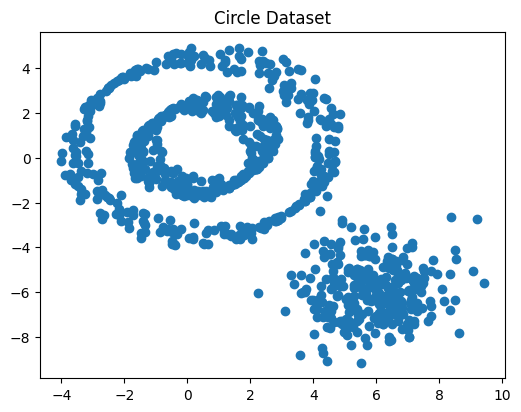

In [3]:
fig,ax = plt.subplots(figsize=(6,4.5))
plt.scatter(circle['x'],circle['y'])
plt.title('Circle Dataset')
plt.show()

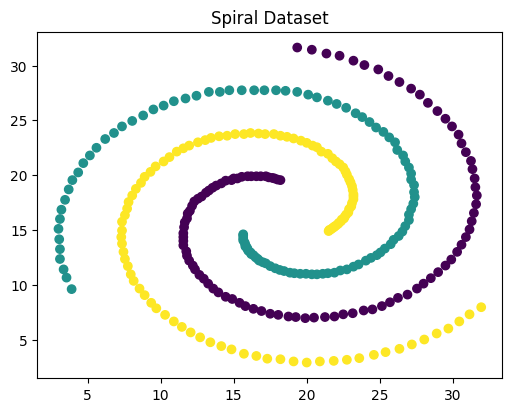

In [4]:
fig,ax = plt.subplots(figsize=(6,4.5))
plt.scatter(spiral['x'],spiral['y'],c=spiral['label'])
plt.title('Spiral Dataset')
plt.show()

In [5]:
circle_points = circle[['x', 'y']].values
spiral_points = spiral[['x', 'y']].values

In [6]:
centers = np.array([[1, 1, 1], [6, 6, 6], [10, 1, 1]])  # 3 distinct centers
X, y = make_blobs(n_samples=2000, centers=centers, n_features=3, random_state=42, cluster_std=0.5)
sorted_indices = np.argsort(y)
X = X[sorted_indices]
y = y[sorted_indices]

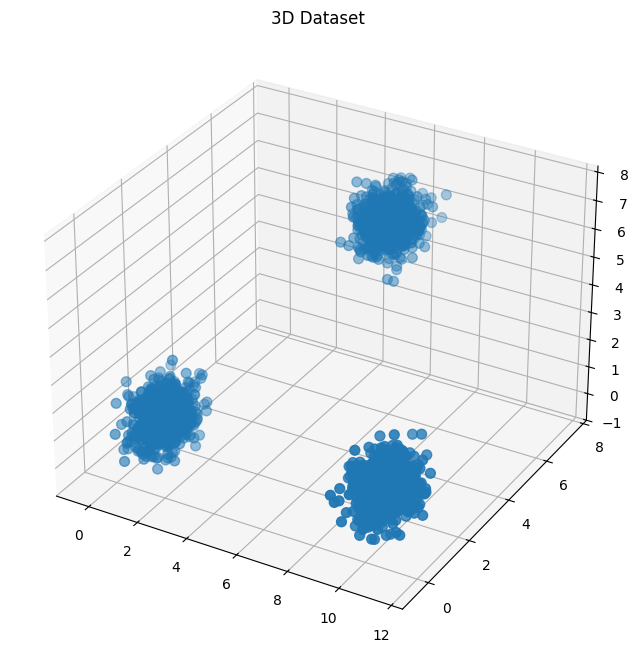

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2],s=50)
plt.title('3D Dataset')
plt.show()

## 2. Define useful functions for the algorithm

### 2.1 Define the similarity function

$$
s_{i,j} = \exp\left(-\frac{\|X_i - X_j\|^2}{2\sigma^2}\right)
$$

In [8]:
def create_similarity_matrix(X, sigma): 

    dist_matrix = pairwise_distances(X, metric='euclidean')
    similarity_matrix = np.exp(-dist_matrix**2 / (2 * sigma**2))
    
    return similarity_matrix


### 2.2 Define function to construct matrix W

In [9]:
def create_adjacency_matrix(X, k, sigma=1):        
    similarity_matrix = create_similarity_matrix(X, sigma)
    np.fill_diagonal(similarity_matrix, 0)  # diagonal elements are zero by definition

    n_points = similarity_matrix.shape[0]
    W = np.zeros_like(similarity_matrix)

    for i in range(n_points):
        row = similarity_matrix[i]
        top_k_indices = np.argsort(row)[-k:]
        W[i, top_k_indices] = row[top_k_indices]

    W = np.maximum(W,W.T) # so that W is symmetric
    return W
 

### 2.3 Define _Inverse Power Method_ and _Deflation Method_ to compute eigenvalues

In [10]:
def inverse_power_method(A, v0, maxIter=1000, relTol=1e-8, p=0):
    v0 = v0 / np.linalg.norm(v0,2)
    l0 = p
    k = 0
    while True:
        v1 = np.linalg.solve(A - p * np.eye(A.shape[0]), v0)  
        mu = np.dot(v1, v0)
        v1 = v1 / np.linalg.norm(v1,2)
        k += 1
        if(k>maxIter or np.abs(mu-l0)<relTol*(np.abs(mu))):
            break
        v0 = v1
        l0 = mu

    return (1/mu)+p, v1

In [11]:
def deflation_method(A, k):
    eigenvalues = []
    A_current = A.copy()
    shift,_ = eigsh(A_current, k=1, which='LA')
    shift = shift + 1e-5
    for _ in range(k):        
        lambda_i, v_i = inverse_power_method(A_current, np.random.rand(A.shape[0]), maxIter=1000, relTol=1e-8, p=0)
        eigenvalues.append(lambda_i)
        A_current = A_current - np.outer(v_i, v_i)*(shift-lambda_i)
    return np.array(eigenvalues)

## 3. Apply _Spectral Clustering_ to the datasets

### 3.1 Circle Dataset

In [12]:
W_10 = create_adjacency_matrix(circle_points, 10)
W_20 = create_adjacency_matrix(circle_points, 20)
W_40 = create_adjacency_matrix(circle_points, 40)
W_10 = csr_matrix(W_10)
W_20 = csr_matrix(W_20)
W_40 = csr_matrix(W_40)

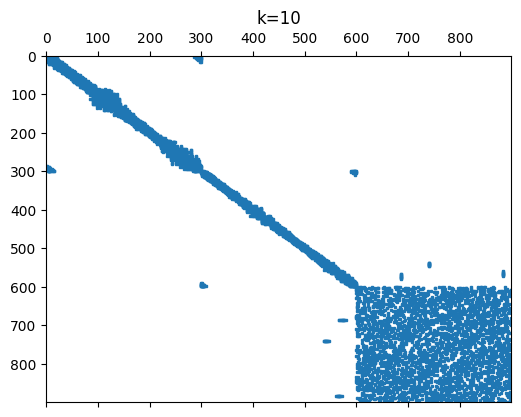

In [13]:
plt.figure(figsize=(6, 4.5))
plt.spy(W_10, markersize=2, aspect='auto')  
plt.title("k=10")
plt.show()

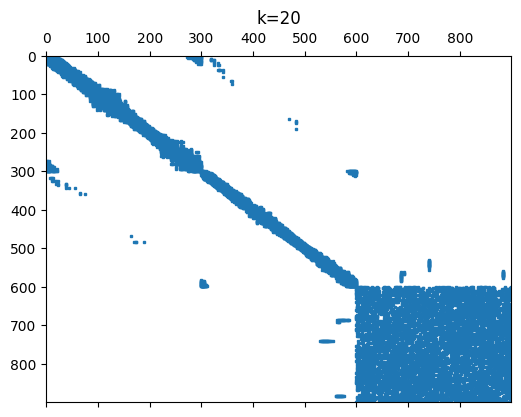

In [14]:
plt.figure(figsize=(6, 4.5))
plt.spy(W_20, markersize=2, aspect='auto')  
plt.title("k=20")
plt.show()

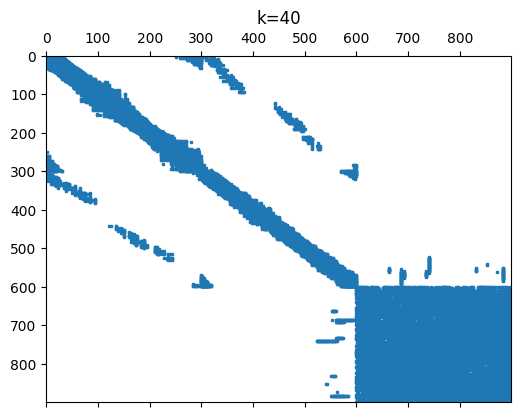

In [15]:
plt.figure(figsize=(6, 4.5))
plt.spy(W_40, markersize=2, aspect='auto')  
plt.title("k=40")
plt.show()

In [16]:
W = W_10.toarray()

Construct the degree matrix D and the Laplacian matrix L = D −W. We apply also the same process to the normalized symmetric Laplacian matrix $L_{\text{sym}} \in \mathbb{R}^{N \times N}$ that is defined as

$$
L_{\text{sym}} := D^{-\frac{1}{2}} L D^{-\frac{1}{2}} = I - D^{-\frac{1}{2}} W D^{-\frac{1}{2}}
$$ 

In [17]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])    
D = csr_matrix(D)
W = csr_matrix(W)

In [18]:
L = D - W
L_sym = D.power(-0.5).dot(L).dot(D.power(-0.5))
L = csr_matrix(L)
L_sym = csr_matrix(L_sym)

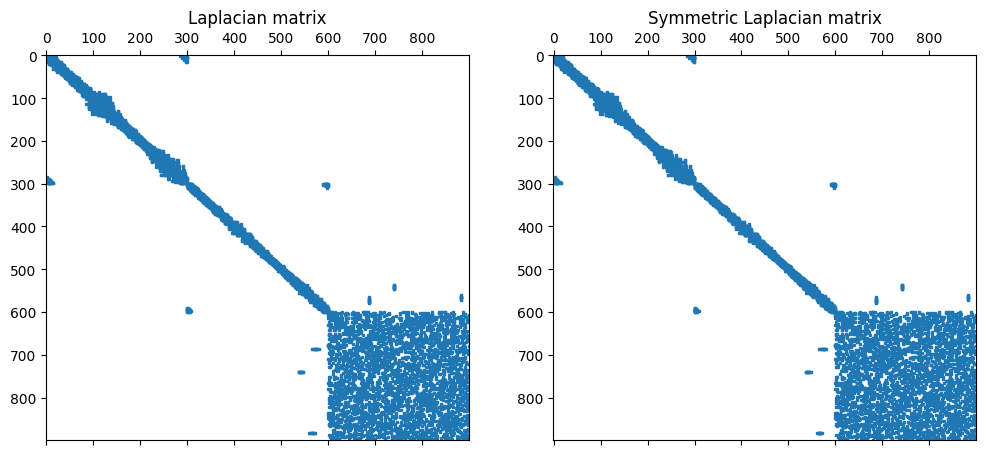

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].spy(L, markersize=2, aspect='auto')
ax[0].set_title('Laplacian matrix')
ax[1].spy(L_sym, markersize=2, aspect='auto')
ax[1].set_title('Symmetric Laplacian matrix')
plt.show()

Compute the number of connected components of the similarity graph.

In [20]:
num_connected_components = circle_points.shape[0] -  np.linalg.matrix_rank(L.toarray(), tol=1e-8)
print("Number of connected components:", num_connected_components)

Number of connected components: 2


Compute some small eigenvalues of L and use their values to choose a
suitable number of clusters M for the points data-sets. We compute the eigenvalues using our implementation of the _Deflation Method_.

In [21]:
eigenvalues = deflation_method(L_sym.toarray(), 15)
eigenvalues_sym = deflation_method(L_sym.toarray(), 15)

In [22]:
# We consider as null all the eigenvalues smaller than 1e-8
print("The multiplicity of the eigenvalue 0 is:", 15-len([x for x in eigenvalues if x>1e-8]))

The multiplicity of the eigenvalue 0 is: 2


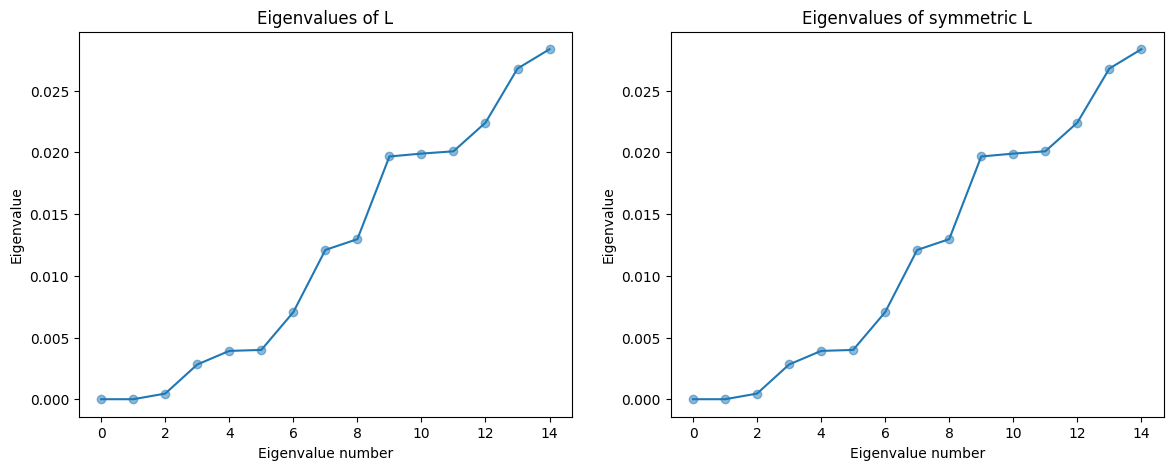

In [23]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
ax[0].scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
ax[0].set_title('Eigenvalues of L')
ax[0].set_xlabel("Eigenvalue number")
ax[0].set_ylabel("Eigenvalue")
ax[1].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues_sym))
ax[1].scatter(np.arange(0,15,step=1), np.sort(eigenvalues_sym), alpha=0.5)
ax[1].set_title('Eigenvalues of symmetric L')
ax[1].set_xlabel("Eigenvalue number")
ax[1].set_ylabel("Eigenvalue")
plt.show()

Compute the $M$ eigenvectors $u_1, u_2, \dots, u_M \in \mathbb{R}^N$ that correspond to the $M$ smallest eigenvalues of the Laplacian matrix. Define the matrix $U \in \mathbb{R}^{N \times M}$ with these eigenvectors as columns. We try with M=2 and M=3.
For $i = 1, \dots, N$, let $\mathbf{y}_i \in \mathbb{R}^M$ be the vector corresponding to the $i$-th row of $U$. Cluster the points $\mathbf{y}_i$, $i = 1, \dots, N$ in $\mathbb{R}^M$ with the $k$-means algorithm into clusters $C_1, \dots, C_M$.

In [24]:
_ , eigenvectors = eigsh(L, k=15, which='SM')
_ , eigenvectors_sym = eigsh(L_sym, k=15, which='SM')

In [25]:
def show_clustering(df, column_name1, column_name2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(df['x'], df['y'], c=df[column_name1])
    ax[0].set_title('Spectral clustering with L')
    ax[1].scatter(df['x'], df['y'], c=df[column_name2])
    ax[1].set_title('Spectral clustering with symmetric L')
    plt.show()

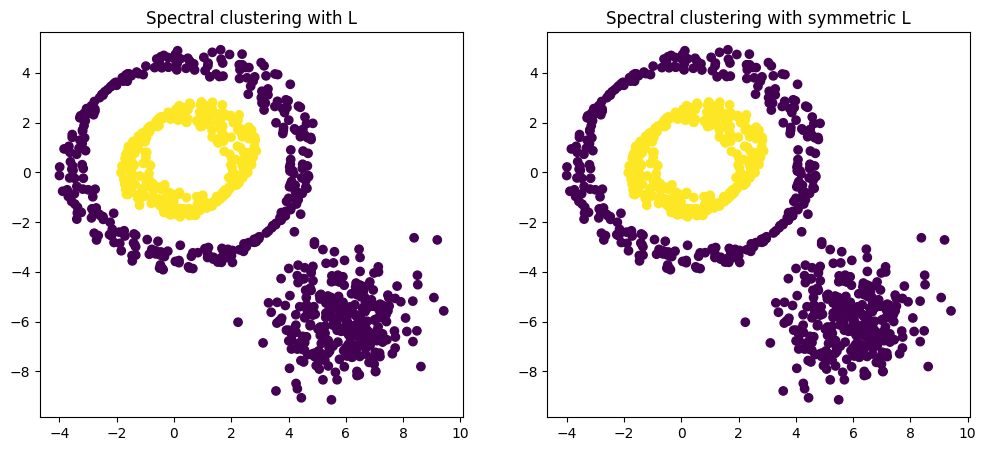

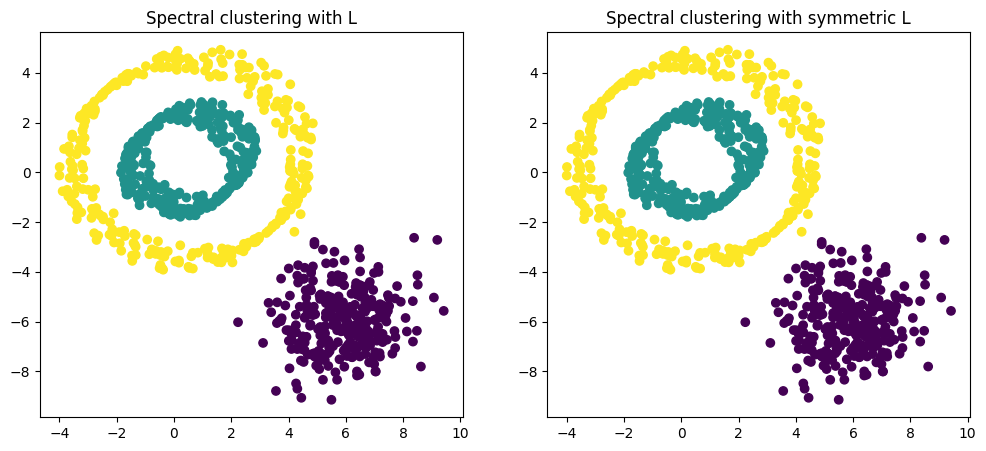

In [26]:
M = [2,3]
for m in M:
    U = eigenvectors[:, 0:m]
    U_sym = eigenvectors_sym[:, 0:m]
    km = KMeans(n_clusters=m)
    km.fit(U)
    circle['cluster'] = km.labels_ 
    circle['cluster_sym'] = km.labels_ 
    show_clustering(circle, "cluster", "cluster_sym")

### 3.2 Spiral Dataset

Apply the same procedure to the _Spiral_ dataset.

In [27]:
W_10 = create_adjacency_matrix(spiral_points, 10)
W_20 = create_adjacency_matrix(spiral_points, 20)
W_40 = create_adjacency_matrix(spiral_points, 40)
W_10 = csr_matrix(W_10)
W_20 = csr_matrix(W_20)
W_40 = csr_matrix(W_40)

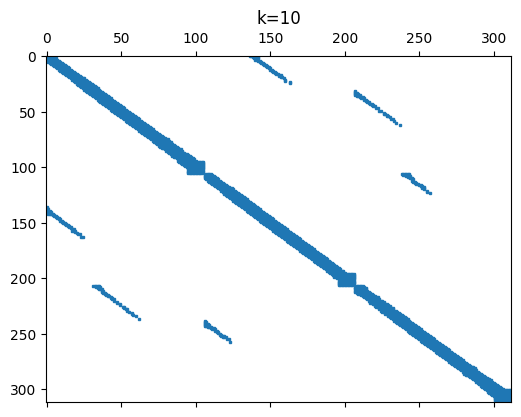

In [28]:
plt.figure(figsize=(6, 4.5))
plt.spy(W_10, markersize=2, aspect='auto')  
plt.title("k=10")
plt.show()

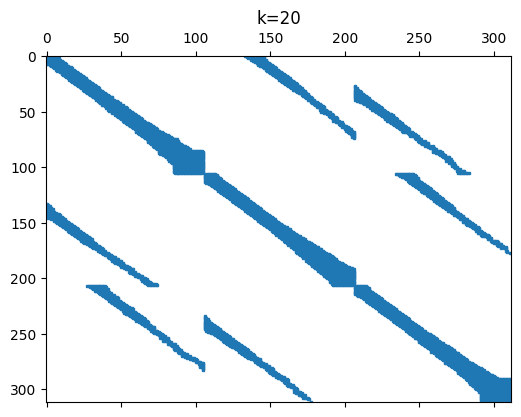

In [29]:
plt.figure(figsize=(6, 4.5))
plt.spy(W_20, markersize=2, aspect='auto')  
plt.title("k=20")
plt.show()

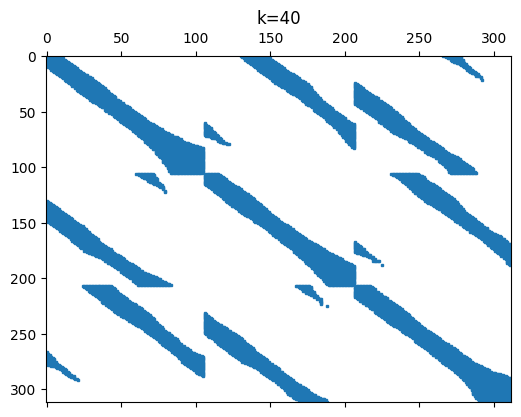

In [30]:
plt.figure(figsize=(6, 4.5))
plt.spy(W_40, markersize=2, aspect='auto')  
plt.title("k=40")
plt.show()

In [31]:
W = W_10.toarray()

In [32]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])   
D = csr_matrix(D) 
W = csr_matrix(W)

In [33]:
L = D - W
L_sym = D.power(-0.5).dot(L).dot(D.power(-0.5))
L = csr_matrix(L)
L_sym = csr_matrix(L_sym)

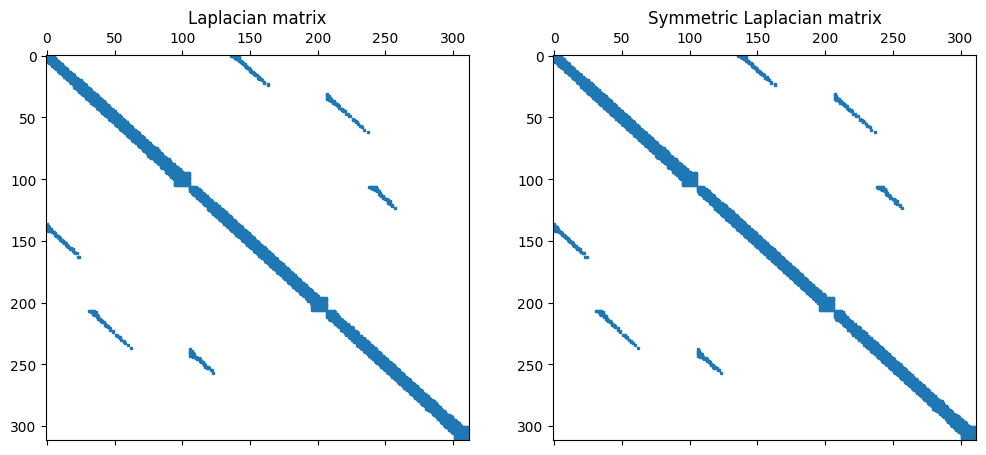

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].spy(L, markersize=2, aspect='auto')
ax[0].set_title('Laplacian matrix')
ax[1].spy(L_sym, markersize=2, aspect='auto')
ax[1].set_title('Symmetric Laplacian matrix')
plt.show()

In [35]:
num_connected_components = spiral_points.shape[0] -  np.linalg.matrix_rank(L.toarray(), tol=1e-3)
print("Number of connected components:", num_connected_components)

Number of connected components: 3


In [36]:
eigenvalues = deflation_method(L.toarray(), 15)
eigenvalues_sym = deflation_method(L_sym.toarray(), 15)

In [37]:
# We consider as null all the eigenvalues smaller than 1e-4
print("The multiplicity of the eigenvalue 0 is:", 15-len([x for x in eigenvalues if x>1e-3]))

The multiplicity of the eigenvalue 0 is: 3


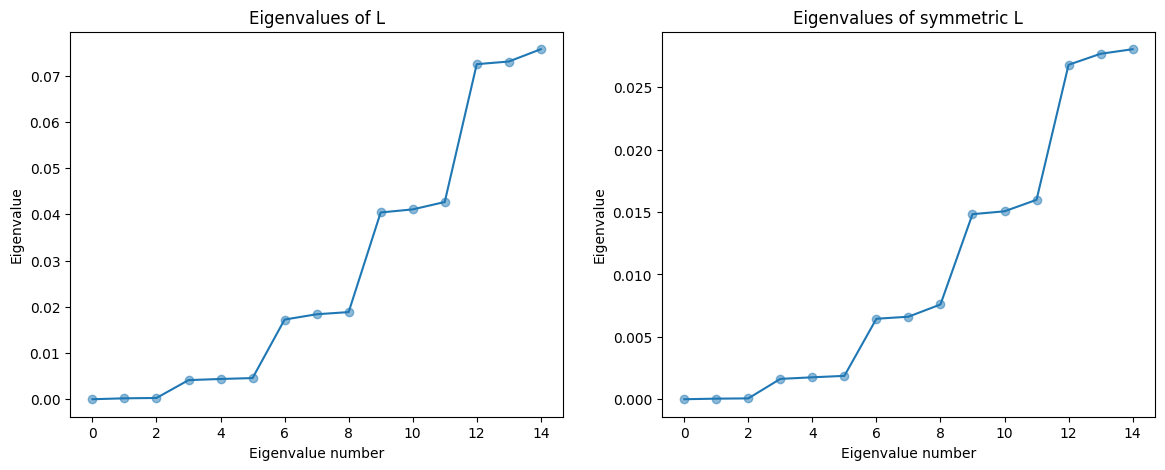

In [38]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
ax[0].scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
ax[0].set_title('Eigenvalues of L')
ax[0].set_xlabel("Eigenvalue number")
ax[0].set_ylabel("Eigenvalue")
ax[1].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues_sym))
ax[1].scatter(np.arange(0,15,step=1), np.sort(eigenvalues_sym), alpha=0.5)
ax[1].set_title('Eigenvalues of symmetric L')
ax[1].set_xlabel("Eigenvalue number")
ax[1].set_ylabel("Eigenvalue")
plt.show()

In [39]:
_ , eigenvectors = eigsh(L, k=15, which='SM')
_ , eigenvectors_sym = eigsh(L_sym, k=15, which='SM')

Adjusted Rand Index (ARI): 1.0


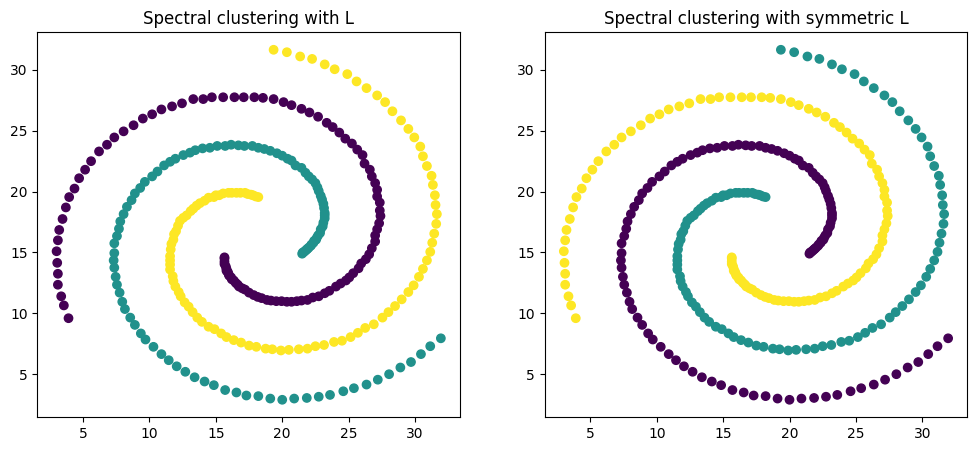

In [40]:
M = [3]
for m in M:
    U = eigenvectors[:, 0:m]
    U_sym = eigenvectors_sym[:, 0:m]
    km = KMeans(n_clusters=m)
    km.fit(U)
    spiral['cluster'] = km.labels_ 
    km.fit(U_sym)
    spiral['cluster_sym'] = km.labels_ 
    ari_score = adjusted_rand_score(spiral['label'], spiral['cluster'])
    print(f"Adjusted Rand Index (ARI): {ari_score}")
    show_clustering(spiral, "cluster", "cluster_sym")

### 3.3 Synthetic 3D Dataset

We try to apply the above procedure to a synthetic dataset of 3D points.

In [41]:
W = create_adjacency_matrix(X, 10)

In [42]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])  

In [43]:
W = csr_matrix(W)
D = csr_matrix(D)

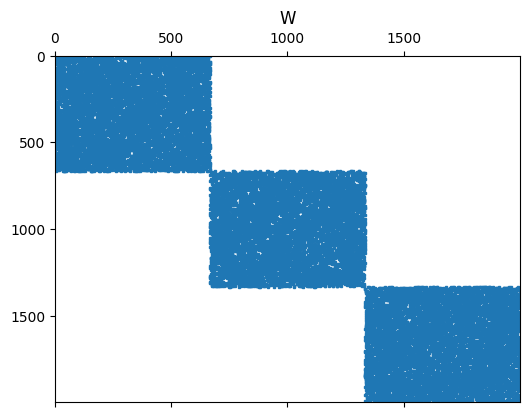

In [44]:
plt.figure(figsize=(6, 4.5))
plt.spy(W, markersize=2,aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

In [45]:
L = D - W
L = csr_matrix(L)

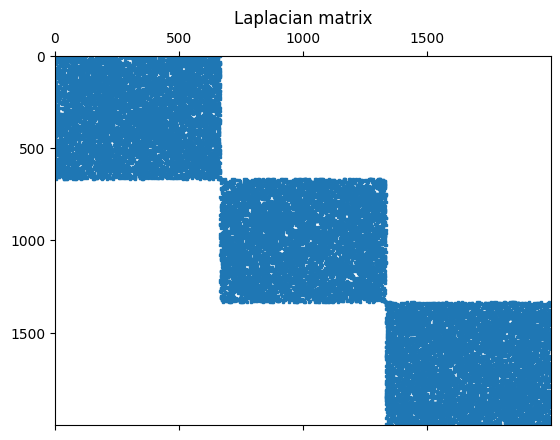

In [46]:
plt.plot( figsize=(12, 5))
plt.spy(L, markersize=2, aspect='auto')
plt.title('Laplacian matrix')
plt.show()

In [47]:
num_connected_components = X.shape[0] -  np.linalg.matrix_rank(L.toarray(), tol=1e-8)
print("Number of connected components:", num_connected_components)

Number of connected components: 3


In [48]:
eigenvalues, eigenvectors = eigsh(L, k=15, which='SM')

In [49]:
# We consider as null all the eigenvalues smaller than 1e-8
print("The multiplicity of the eigenvalue 0 is:", 15-len([x for x in eigenvalues if x>1e-8]))

The multiplicity of the eigenvalue 0 is: 3


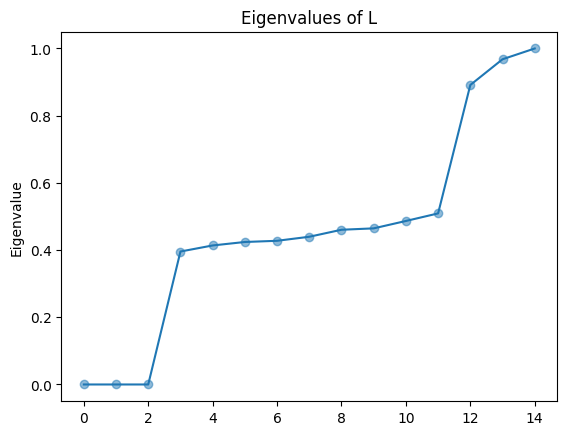

In [50]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
plt.plot(figsize=(14, 5))
plt.plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
plt.scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
plt.title('Eigenvalues of L')
plt.ylabel("Eigenvalue")
plt.show()

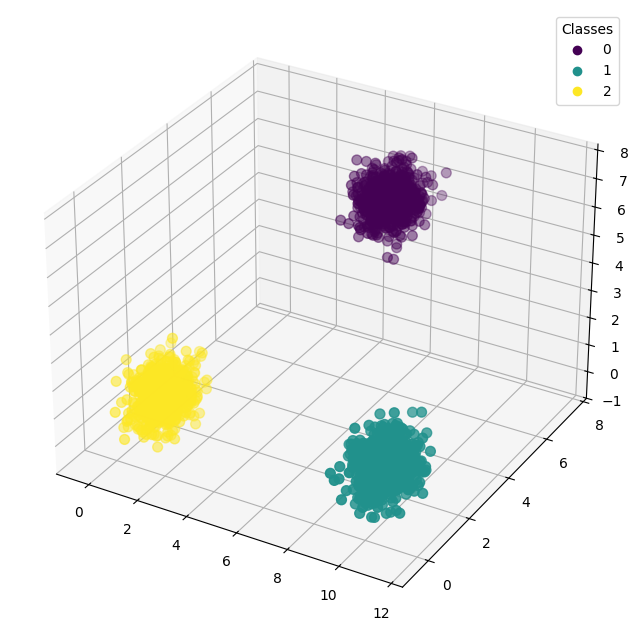

In [51]:
M = [3]
for m in M:
    U = eigenvectors[:, 0:m] 
    km = KMeans(n_clusters=m)
    km.fit(U)
    y_pred = km.labels_ 
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred, s=50)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

In [52]:
ari_score = adjusted_rand_score(y, y_pred)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 1.0


## 4. Try different clustering algorithms

### 4.1 K-means algorithm

In [53]:
km = KMeans(n_clusters=3)
km.fit(circle_points)

KMeans(n_clusters=3)

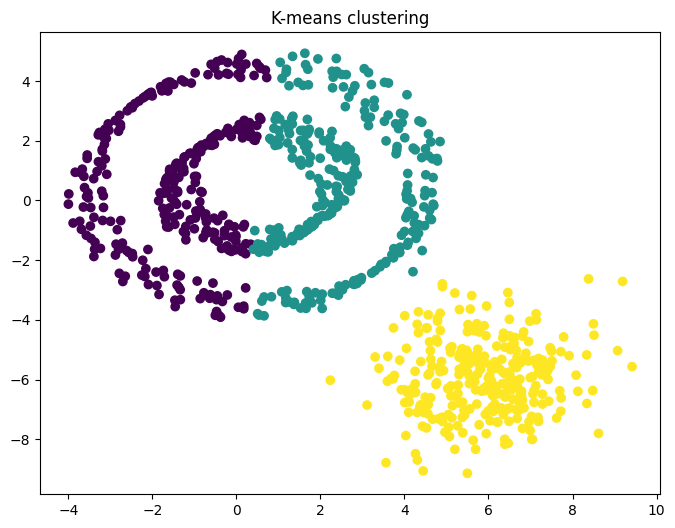

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(circle['x'], circle['y'], c=km.labels_)
plt.title("K-means clustering")
plt.show()

In [55]:
km = KMeans(n_clusters=3)
km.fit(spiral_points)

KMeans(n_clusters=3)

In [56]:
ari_score = adjusted_rand_score(spiral['label'], km.labels_)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): -0.005658233169106526


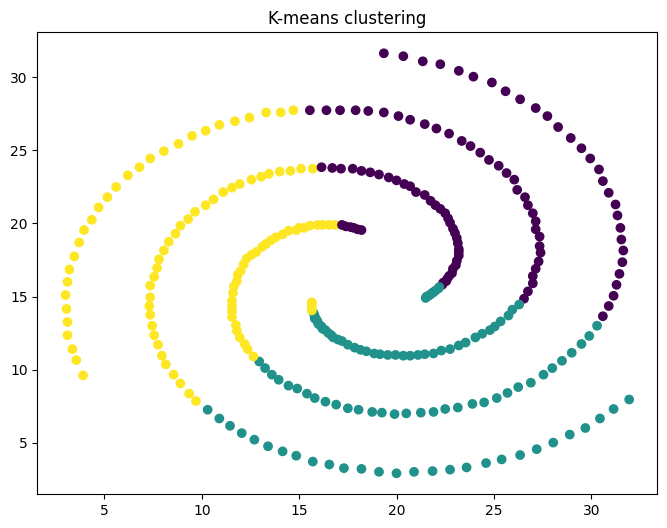

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(spiral['x'], spiral['y'], c=km.labels_)
plt.title("K-means clustering")
plt.show()

In [58]:
km = KMeans(n_clusters=3)
km.fit(X)

KMeans(n_clusters=3)

In [59]:
ari_score = adjusted_rand_score(y,km.labels_)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 1.0


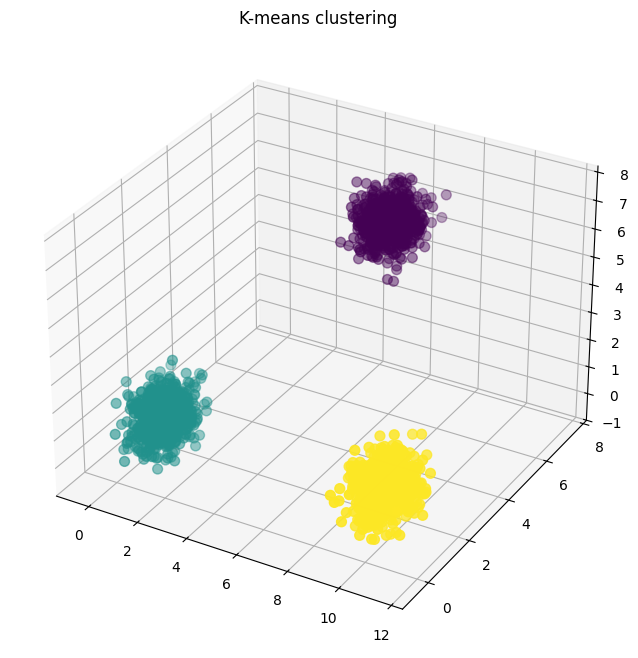

In [60]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=km.labels_, s=50)
plt.title("K-means clustering")
plt.show()

### 4.2 DBSCAN Algorithm

In [61]:
cls = DBSCAN()
cls.fit(circle_points)

DBSCAN()

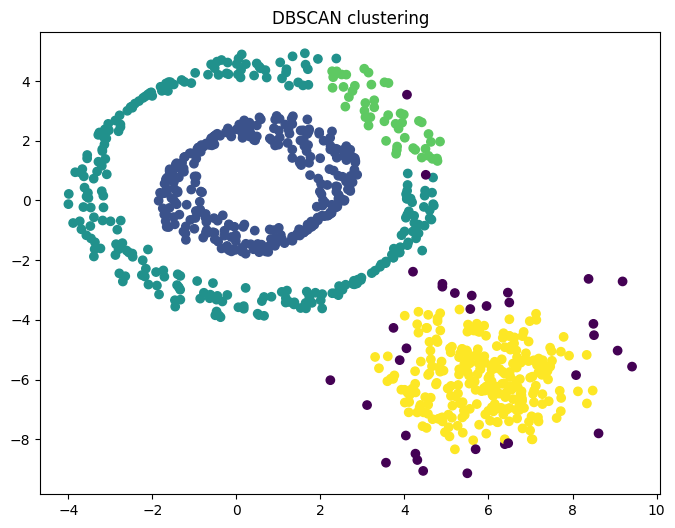

In [62]:
plt.figure(figsize=(8, 6))
plt.scatter(circle['x'], circle['y'], c=cls.labels_)
plt.title("DBSCAN clustering")
plt.show()

In [63]:
cls.fit(spiral_points)

DBSCAN()

In [64]:
ari_score = adjusted_rand_score(spiral['label'],cls.labels_)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 0.011603053827458375


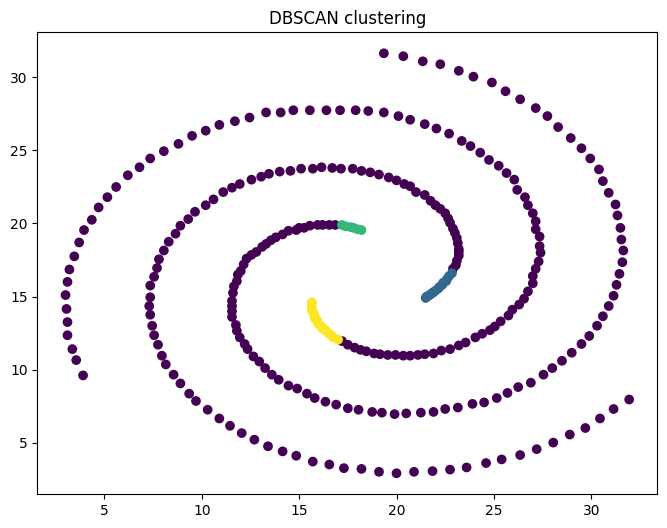

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(spiral['x'], spiral['y'], c=cls.labels_)
plt.title("DBSCAN clustering")
plt.show()

In [66]:
cls.fit(X)

DBSCAN()

In [67]:
ari_score = adjusted_rand_score(y,cls.labels_)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 0.9856695058536742


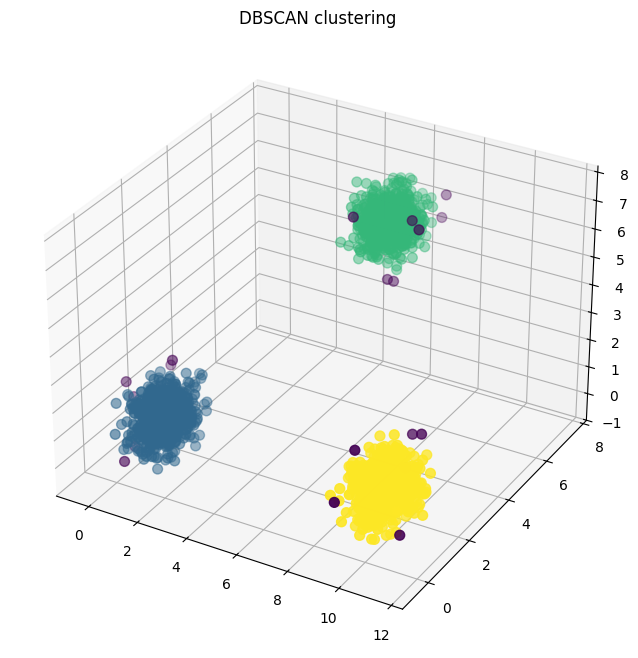

In [68]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=cls.labels_, s=50)
plt.title("DBSCAN clustering")
plt.show()